# 3D Convonlutional Neural Network

#### Install dependencies

In [12]:
%pip install tensorflow[and-cuda] keras gdown

Note: you may need to restart the kernel to use updated packages.


#### Prepare imports

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt
import gdown
import os

#### Download data and model files

In [14]:
ROOT = "./data"
PRETRAINED_MODEL_PATH = ROOT + '/pretrained_3d_cnn.h5'
MODEL_PATH = ROOT + '/3d_cnn.keras'
DATSET_PATH = ROOT + '/full_dataset_vectors.h5'

os.makedirs(ROOT, exist_ok=True)

gdown.download(
    'https://drive.google.com/uc?id=1-jDaDuk5ePsRtS1TU85zJ2euBUPc05mU',
    DATSET_PATH,
    quiet=False
)
gdown.download(
    'https://drive.google.com/uc?id=1EG5g_xYCH7gtV6Zdrt1F_h6AQRQHzyGd',
    PRETRAINED_MODEL_PATH,
    quiet=False
)

Downloading...
From: https://drive.google.com/uc?id=1-jDaDuk5ePsRtS1TU85zJ2euBUPc05mU
To: /mnt/d/FILES/Code/Teaching/diiP2024_SL_Solutions/data/full_dataset_vectors.h5
100%|██████████| 30.6M/30.6M [00:00<00:00, 47.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EG5g_xYCH7gtV6Zdrt1F_h6AQRQHzyGd
To: /mnt/d/FILES/Code/Teaching/diiP2024_SL_Solutions/data/pretrained_3d_cnn.h5
100%|██████████| 2.35M/2.35M [00:00<00:00, 9.61MB/s]


'./data/pretrained_3d_cnn.h5'

#### Model configuration

In [15]:
batch_size = 100
no_epochs = 30
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1

#### Helper functions

In [16]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
  return np.asarray(data_t, dtype=np.float32)

#### Load the dataset from the downloaded data file

In [17]:
# Load the HDF5 data file
with h5py.File(DATSET_PATH, "r") as hf:

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.int64)
    targets_test = to_categorical(targets_test).astype(np.int64)

#### Create the model

In [18]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

#### Load a pretrained model

In [19]:
pretrained_model = tensorflow.keras.models.load_model(PRETRAINED_MODEL_PATH)

#### Train the model

In [20]:
# Compile the model
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# Fit model to data 
history = model.fit(X_train, targets_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)
model.save(MODEL_PATH)

Epoch 1/30
80/80 [==============================] - 2s 27ms/step - loss: 2.0773 - accuracy: 0.2788 - val_loss: 1.6892 - val_accuracy: 0.4335
Epoch 2/30
80/80 [==============================] - 2s 25ms/step - loss: 1.4634 - accuracy: 0.5011 - val_loss: 1.3357 - val_accuracy: 0.5405
Epoch 3/30
80/80 [==============================] - 2s 23ms/step - loss: 1.2253 - accuracy: 0.5742 - val_loss: 1.2100 - val_accuracy: 0.5820
Epoch 4/30
80/80 [==============================] - 2s 23ms/step - loss: 1.1084 - accuracy: 0.6194 - val_loss: 1.1374 - val_accuracy: 0.6000
Epoch 5/30
80/80 [==============================] - 2s 23ms/step - loss: 1.0030 - accuracy: 0.6540 - val_loss: 1.0830 - val_accuracy: 0.6150
Epoch 6/30
80/80 [==============================] - 2s 22ms/step - loss: 0.9455 - accuracy: 0.6769 - val_loss: 1.0684 - val_accuracy: 0.6265
Epoch 7/30
80/80 [==============================] - 2s 21ms/step - loss: 0.8727 - accuracy: 0.7032 - val_loss: 1.0403 - val_accuracy: 0.6460
Epoch 8/30
80

#### Test the models

In [21]:
# Generate generalization metrics
score_pretrained = pretrained_model.evaluate(X_test, targets_test, verbose=0)
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Pretrained model. Test loss: {score_pretrained[0]} / Test accuracy: {score_pretrained[1]}')
print(f'Trained model. Test loss: {score[0]} / Test accuracy: {score[1]}')

Pretrained model. Test loss: 1.7864867448806763 / Test accuracy: 0.6679999828338623
Trained model. Test loss: 1.8108198642730713 / Test accuracy: 0.6694999933242798


#### Plot losses

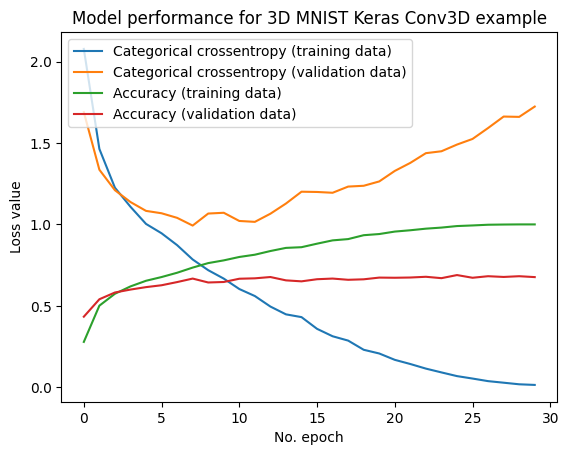

In [22]:

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()